### IMPORT PACKAGES

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

### FUNCTION

In [50]:
#split feature columns
def group_feature(df=pd.DataFrame):
    numeric = list(df.select_dtypes(include=[int,float]))
    category = list(df.select_dtypes(exclude=[int,float]))
    return numeric,category

#function check outlier
def check_outliers(column = str, df = pd.DataFrame):
    values = {}
    for j,i in enumerate(column):
        print(j,i)
        Q3 = df[i].quantile(q=0.75)
        Q1 = df[i].quantile(q=0.25)
        IQR = Q3 - Q1
        min_IQR = Q1 - 1.5 * IQR
        max_IQR = Q3 + 1.5 * IQR
        results_top = []
        results_down = []
        for index,val in enumerate(df[i]):
            if (val < min_IQR):
                results_down.append(val)
            elif (val > max_IQR):
                results_top.append(val)
        print(f"column :{i}\nnum_outliers:{len(results_top) + len(results_down)}\n")
        values [j] = [results_top,results_down]
    return values

def VIF_table(X_dataframe:pd.DataFrame):
    VIF_value  =[variance_inflation_factor(X_dataframe.values,i) for i in range(len(X_dataframe.columns))]
    VIF_columns = list(X_dataframe.columns)
    
    return pd.DataFrame({'col' : VIF_columns,'val' :VIF_value})

### BUSSINESS UNDERSTANDING
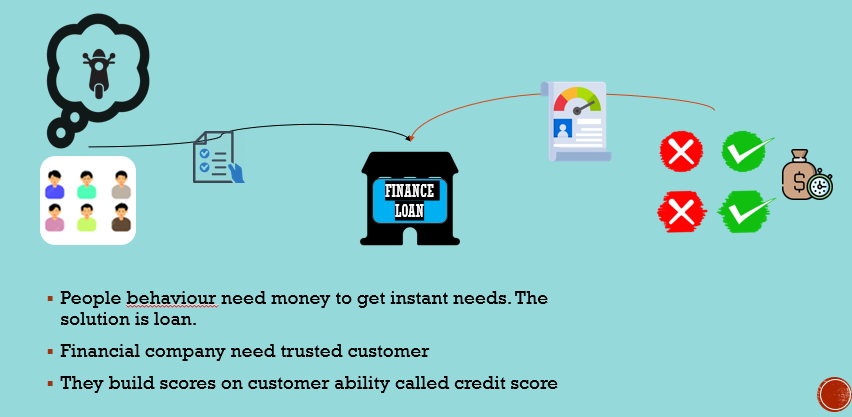

PURPOSE = To predict CREDIT SCORE as integer (350-850), berdasarkan data pemohon kredit potensial. yang berarti semakin tinggi skor pemohon dapat terpercaya diberikan pinjaman kredit untuk motor di india.

Value = meminimalisir kerugian akibat peminjam yang tidak membayar atau telat membayar
matrix = rmse dan mse 

example :

1 lakh = 100.000 rupee
ir = interest rate/suku bunga

range two wheeler loan 1-50 lakh:

8-12 % = loan with low interest rate, 50 lakh , ir 8% = 400.000, if in a year  
base 416.666 rupee/month + ir 33.333 rupee/month = 450.000/5000.000 = 9 %  minimize loss for the first month onward

12-15 % = loan with normal interest rate, 50 lakh , ir 12% = 600.000, if in a year  
base 416.666 rupee/month + ir 50.000 rupee/month = 466.666/5000.000 = 9,3 %  minimize loss for the first month onward

15-20 % = loan with high interest rate, 50 lakh , ir 15% = 750.000, if in a year  
base 416.666 rupee/month + ir 62.500 rupee/month = 479.166/5000.000 = 9,5 % minimize loss for the first month onwards

20-25 % = no loan or high interest rate if do loan, 50 lakh / 5.000.000 rupee,ir 20% =  1000.000, if in a year 
base 416.666 rupee/month + ir 83.333 rupee/month = 500.000/ 5000.000 = 10 % we can minimize loss up to 10 % for the first month onwards.

for credit score below 300 (base on fico credit score), we can reject loan submission and save 100 % / 50 lakh for the highest loan value

### cibil score (india) source IIFL finance.com

Excellent Credit Score - Around 750 and above
These Individuals are likely to have a high likelihood of loan approval and can access loans and credit at favourable terms, including lower interest rates.

Good Credit Score - In the range of 700 to 749
This scoring range also signifies a strong credit profile, and individuals within this range are generally considered reliable borrowers by lenders.

Fair Credit Score - Ranges from 650 to 699
Individuals with fair credit scores can have access to credit, but they might face slightly higher interest rates or more stringent lending conditions than those with higher scores.

Poor Credit Score - Below 650
They may face challenges in obtaining credit or loans as lenders may be more cautious due to the perceived higher credit risk.


### Fico credit score (US) mybanktracker.com 

300-580	Very Bad:	
Extremely difficult to obtain traditional loans and line of credit. Advised to use secured credit cards and loans to help rebuild credit.

580-669	Bad:
May be able to qualify for some loans and lines of credit, but the interest rates are likely to be high.

670-739	Average/Fair:
Eligible for many traditional loans, but the interest rates and terms may not be the best.

740-799	Good:
Valuable benefits come in the form of loans and lines of credit with comprehensive perks and low interest rates.

800-850	Excellent:
Qualify easily for most loans and lines of credit with low interest rates and favorable terms.

In [27]:
df = pd.read_csv('C:/Users/hp/Downloads/NEW PROJECT/credit_data.csv')
df.head(3)

,Age,Gender,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation
0,31,Male,36000,604,487,5,109373,221,No,Karnataka,Mysuru,90.943430,Salaried,77,Doctor
1,25,Male,50000,447,386,2,150000,89,No,Karnataka,Bengaluru,91.135253,Salaried,43,Software Engineer
2,62,Other,178000,850,503,10,69099,110,Yes,Uttar Pradesh,Kanpur,40.000000,Salaried,90,Banker


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279856 entries, 0 to 279855
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       279856 non-null  int64  
 1   Gender                    279856 non-null  object 
 2   Income                    279856 non-null  int64  
 3   Credit Score              279856 non-null  int64  
 4   Credit History Length     279856 non-null  int64  
 5   Number of Existing Loans  279856 non-null  int64  
 6   Loan Amount               279856 non-null  int64  
 7   Loan Tenure               279856 non-null  int64  
 8   Existing Customer         279856 non-null  object 
 9   State                     279856 non-null  object 
 10  City                      279856 non-null  object 
 11  LTV Ratio                 279856 non-null  float64
 12  Employment Profile        279856 non-null  object 
 13  Profile Score             279856 non-null  i

### DICTIONARY

Age:
Type: Integer\
Description: Represents the age of the applicant. Indicates the applicant's maturity level.\
Range: 18 to 70

Gender:
Type: Categorical\
Description: Gender of the applicant.\
Categories: Male, Female, Other

Income:
Type: Integer\
Description: The applicant's income, which is critical in assessing their ability to repay the loan.\
Range: Multiples of 1000's

Credit Score:
Type: Integer\
Description: A score quantifying the applicant's creditworthiness based on their credit history.\
Range: 300 to 850

Credit History Length:
Type: Integer\
Description: Represents the number of months since the applicant's first credit line. Indicates the applicant's experience with credit management.\
Units: Months

Number of Existing Loans:
Type: Integer\
Description: The number of loans the applicant currently has.\
Range: 0 to 10

Loan Amount:
Type: Integer\
Description: The amount of money the applicant is requesting.\
Range: 0 to 150,000

Loan Tenure:
Type: Integer\
Description: The number of months the applicant wants to repay the loan over.\
Units: Months

Existing Customer:
Type: Categorical\
Description: Whether the applicant is an existing customer of the finance company.\
Categories: Yes, No

State:
Type: Categorical\
Description: The state in India where the applicant resides.\
Categories: Maharashtra, Delhi, Karnataka, Tamil Nadu, West Bengal, Uttar Pradesh, Gujarat, Rajasthan, Kerala, Telangana, etc.

City:
Type: Categorical\
Description: The city or village in India where the applicant resides.\
Categories: Mumbai, Pune, New Delhi, Bengaluru, Chennai, Kolkata, Ahmedabad, Jaipur, Kochi, Hyderabad, and various villages.

LTV Ratio:
Type: Float\
Description: The loan-to-value ratio, represents the ratio of the loan amount to the appraised value of the asset (typically a house). Higher LTVs can indicate higher risk.\
Range: 40% to 95%

Employment Profile:
Type: Categorical\
Description: General employment category of the applicant.\
Categories: Salaried, Self-Employed, Freelancer, Unemployed, Student

Occupation:
Type: Categorical\
Description: Specific occupation or job title of the applicant.\
Categories: Software Engineer, Doctor, Teacher, Business Owner, Writer, etc.

Profile Score:
Type: Integer\
Description: A score ranging from 0 to 100 represents the overall profile of the applicant based on the actual loan repayment data. Higher values indicate better profiles.\
Range: 0 to 100

### DATA PREPARATION

In [4]:
#duplicated handling

df.duplicated(subset=list(df.columns)).sum()
# ada banyak sekali record double

100814

In [5]:
#value check
df[df.duplicated(subset=list(df.columns),keep=False)].sort_values(by= list(df.columns)).head(5)

,Age,Gender,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,Existing Customer,State,City,LTV Ratio,Employment Profile,Profile Score,Occupation
22723,18,Female,9000,300,500,0,36631,26,No,West Bengal,Kolkata,95.000000,Salaried,24,Software Engineer
176804,18,Female,9000,300,500,0,36631,26,No,West Bengal,Kolkata,95.000000,Salaried,24,Software Engineer
137592,18,Female,9000,328,235,0,44422,112,No,West Bengal,Kolkata,84.429872,Salaried,57,Doctor
249155,18,Female,9000,328,235,0,44422,112,No,West Bengal,Kolkata,84.429872,Salaried,57,Doctor
112528,18,Female,9000,341,350,0,43265,69,No,Telangana,Hyderabad,69.521039,Salaried,62,Software Engineer


In [3]:
#drop duplicated row
df = df.drop_duplicates(subset=list(df.columns))

In [7]:
#check missing value
df.isnull().sum()

Age                             0
Gender                          0
Income                          0
Credit Score                    0
Credit History Length           0
Number of Existing Loans        0
Loan Amount                     0
Loan Tenure                     0
Existing Customer               0
State                           0
City                            0
LTV Ratio                       0
Employment Profile              0
Profile Score                   0
Occupation                  11690
dtype: int64

In [8]:
11690/ len(df)
# ada 0.06 % missing value pada occupation

0.06529194267266898

<AxesSubplot:>

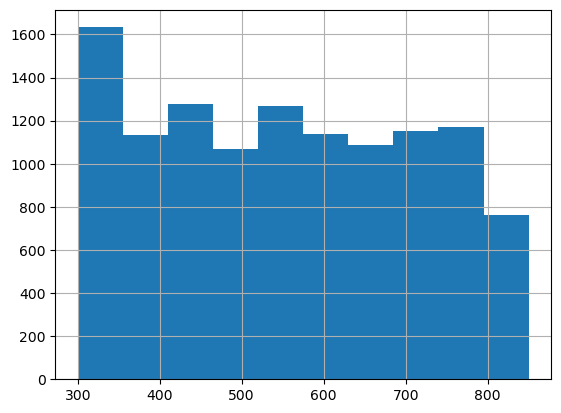

In [9]:
ds = df[df['Occupation'].isnull()]
ds['Credit Score'].hist()

#nilai null mengarah ke lebih banyak yang credit score menengah hingga rendah namun tidak signifikan

In [4]:
#drop missing value
df = df.dropna(subset='Occupation')

In [11]:
#check target value
print('credit score:','\n','min',df['Credit Score'].min(),'\n','max:',df['Credit Score'].max())

credit score: 
 min 300 
 max: 850


<AxesSubplot:>

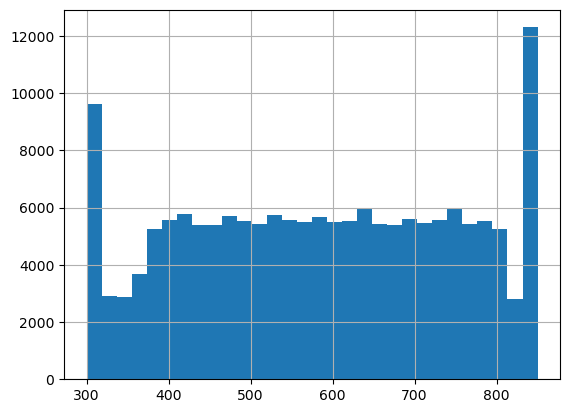

In [12]:
df['Credit Score'].hist(bins=30)
# i think not bad, dan ada fokus bahwa banyak yang 300 dan diatas 800 credit scorenya

In [47]:
# split feature 
numeric,category = group_feature(df)

In [14]:
#numeric feature
df[numeric].describe()

,Age,Income,Credit Score,Credit History Length,Number of Existing Loans,Loan Amount,Loan Tenure,LTV Ratio,Profile Score
count,167352.000000,167352.000000,167352.000000,167352.000000,167352.000000,167352.000000,167352.000000,167352.000000,167352.000000
mean,44.192002,77432.573259,585.156048,307.855938,4.742190,106110.248662,134.022211,71.538415,78.235605
std,15.316458,43253.577271,163.050878,175.019930,2.982081,40326.455700,96.248890,16.888209,23.896138
min,18.000000,9000.000000,300.000000,6.000000,0.000000,5294.000000,12.000000,40.000000,0.000000
25%,31.000000,43000.000000,449.000000,156.000000,2.000000,72701.000000,62.000000,57.946711,62.000000
50%,44.000000,69000.000000,587.000000,306.000000,5.000000,111705.000000,101.000000,72.026525,90.000000
75%,57.000000,106000.000000,725.000000,460.000000,7.000000,150000.000000,202.000000,86.118411,98.000000
max,70.000000,209000.000000,850.000000,611.000000,10.000000,150000.000000,359.000000,95.000000,100.000000


In [15]:
#skewness check
df[numeric].skew()

Age                        -0.019106
Income                      0.681517
Credit Score               -0.047429
Credit History Length       0.011794
Number of Existing Loans    0.045199
Loan Amount                -0.447091
Loan Tenure                 0.831772
LTV Ratio                  -0.175749
Profile Score              -1.054118
dtype: float64

In [ ]:
# masih dianggap normal jika mengacu batas skew 2.0 dan -2.0

In [16]:
#category feature
df[category].describe()

,Gender,Existing Customer,State,City,Employment Profile,Occupation
count,167352,167352,167352,167352,167352,167352
unique,3,2,10,23,4,14
top,Female,No,West Bengal,Kolkata,Salaried,Banker
freq,77515,103284,16937,14428,87138,17788


In [ ]:
# gender ada other namun kita abaikan dulu dalam model
#existing customer binary

In [17]:
# check value category
for i in category:
    print(df[i].value_counts())

Female    77515
Male      77372
Other     12465
Name: Gender, dtype: int64
No     103284
Yes     64068
Name: Existing Customer, dtype: int64
West Bengal      16937
Karnataka        16841
Telangana        16791
Gujarat          16782
Kerala           16728
Maharashtra      16713
Delhi            16701
Uttar Pradesh    16681
Tamil Nadu       16677
Rajasthan        16501
Name: State, dtype: int64
Kolkata               14428
New Delhi             14237
Hyderabad             14138
Kanpur                 7259
Mysuru                 7237
Surat                  7185
Thiruvananthapuram     7183
Udaipur                7167
Coimbatore             7064
Bengaluru              7062
Ahmedabad              7060
Chennai                7053
Lucknow                7003
Kochi                  6992
Jaipur                 6872
Manjari                5145
Dhulagori              5119
Bishanpura             5042
Channarayapatna        4927
Nellikuppam            4923
Mumbai                 4860
Nagpur         

In [55]:
# d_skew = ['Profile Score']
# outlier = check_outliers(d_skew,df)

### DATA VISUALIZATION

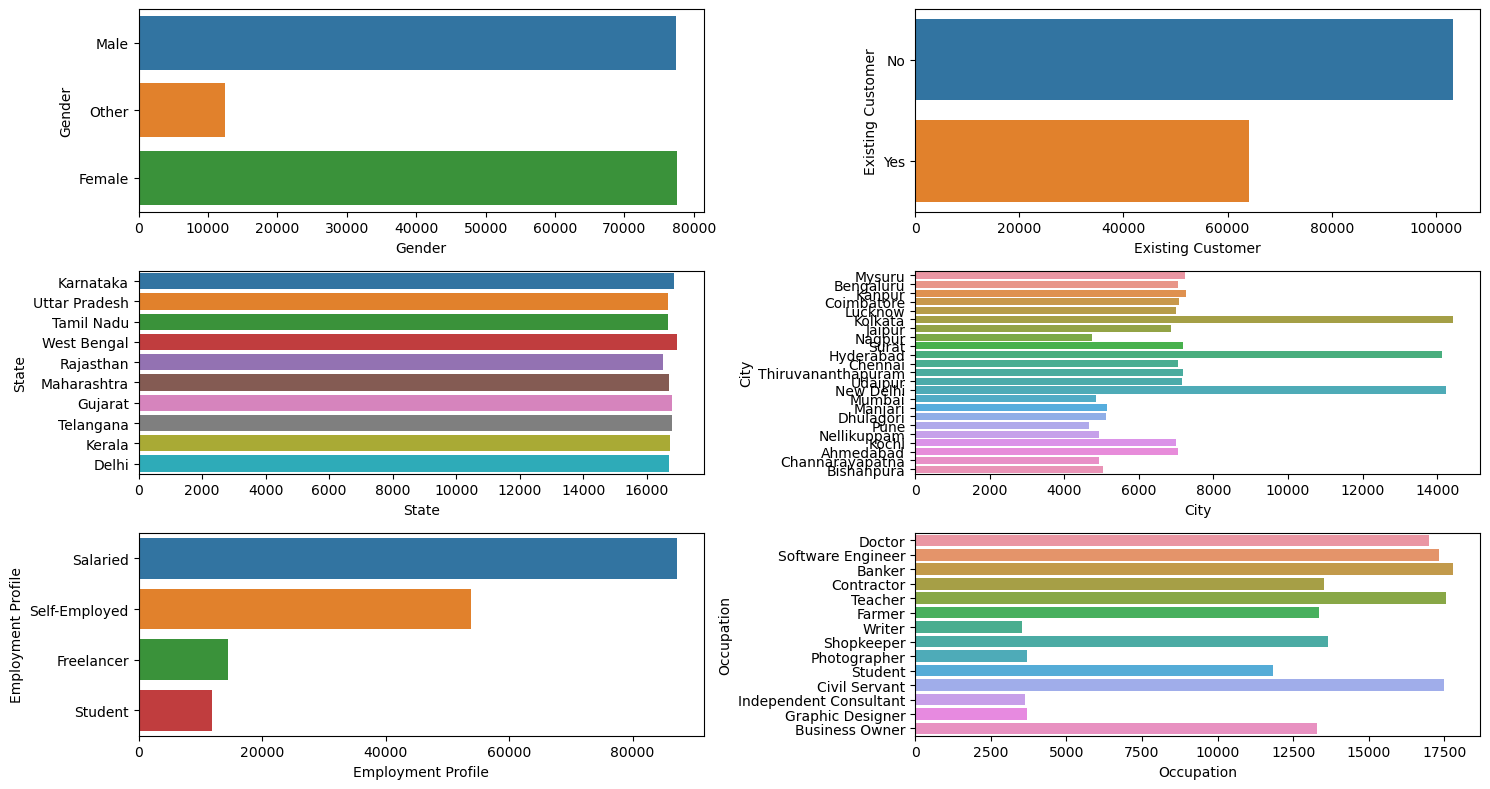

In [7]:
#category UNIVARIATE

plt.figure(figsize=(15,8))
index = 1

for i in category:
    plt.subplot(3,len(category)//3,index)
    sns.countplot(y=df[i])
    index += 1
    plt.xlabel(i)
    plt.tight_layout()

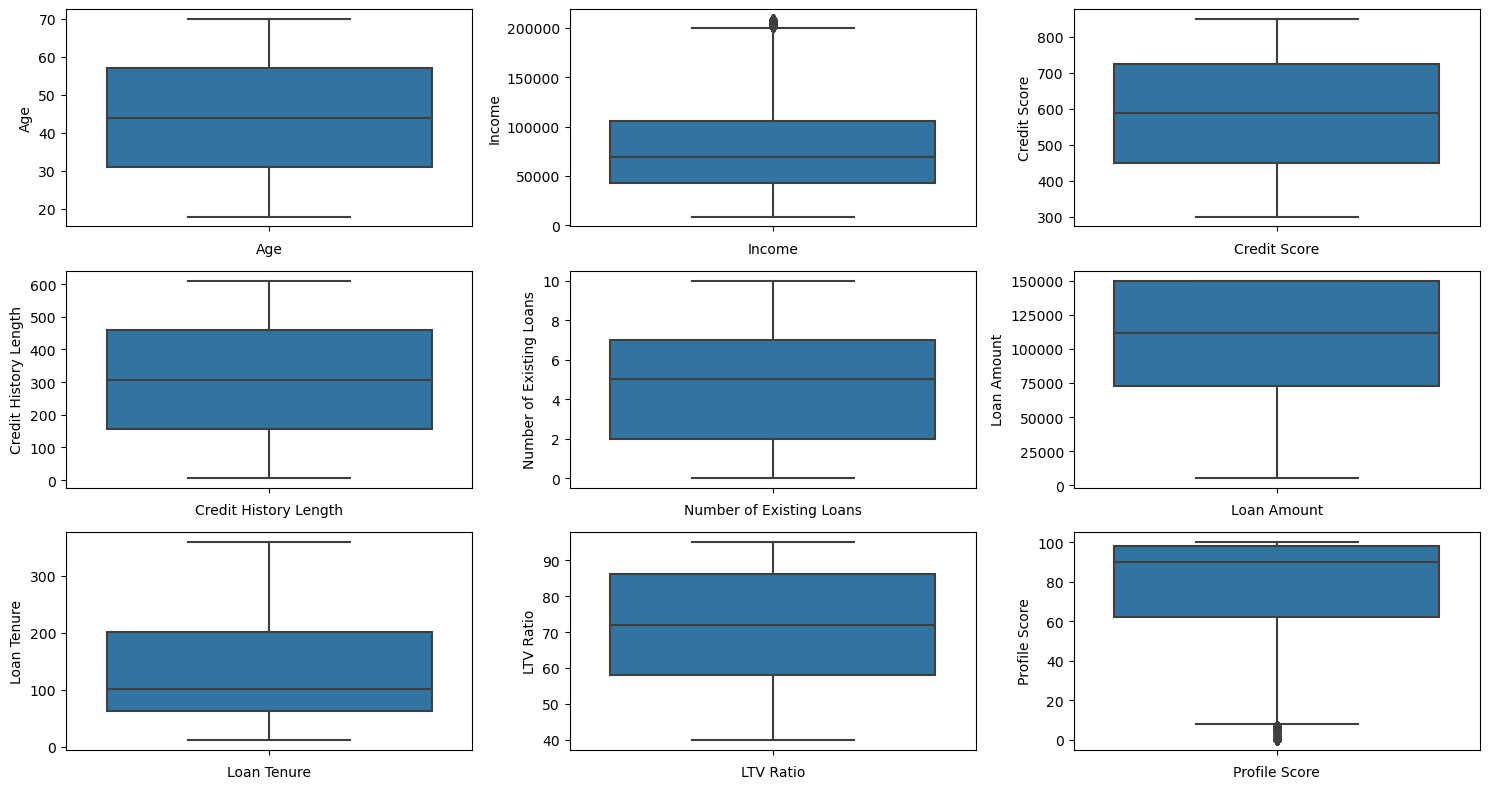

In [8]:
plt.figure(figsize=(15,8))
index = 1

for i in numeric:
    plt.subplot(3,len(numeric)//3,index)
    sns.boxplot(y=df[i])
    index += 1
    plt.xlabel(i)
    plt.tight_layout()

<AxesSubplot:xlabel='Profile Score', ylabel='Profile Score'>

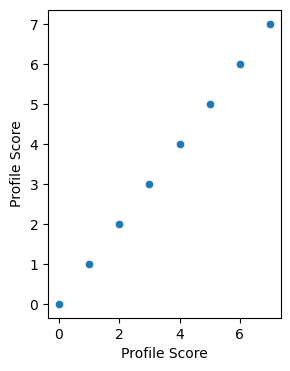

In [7]:
down = values[0][1] 
s = df[df['Profile Score'].isin(down)]
plt.figure(figsize=(3,4))
index = 1
sns.scatterplot(x=s['Profile Score'],y= s['Profile Score'])

In [8]:
# df = df[~(df['Profile Score'].isin(down))]

### EDA VISUAL

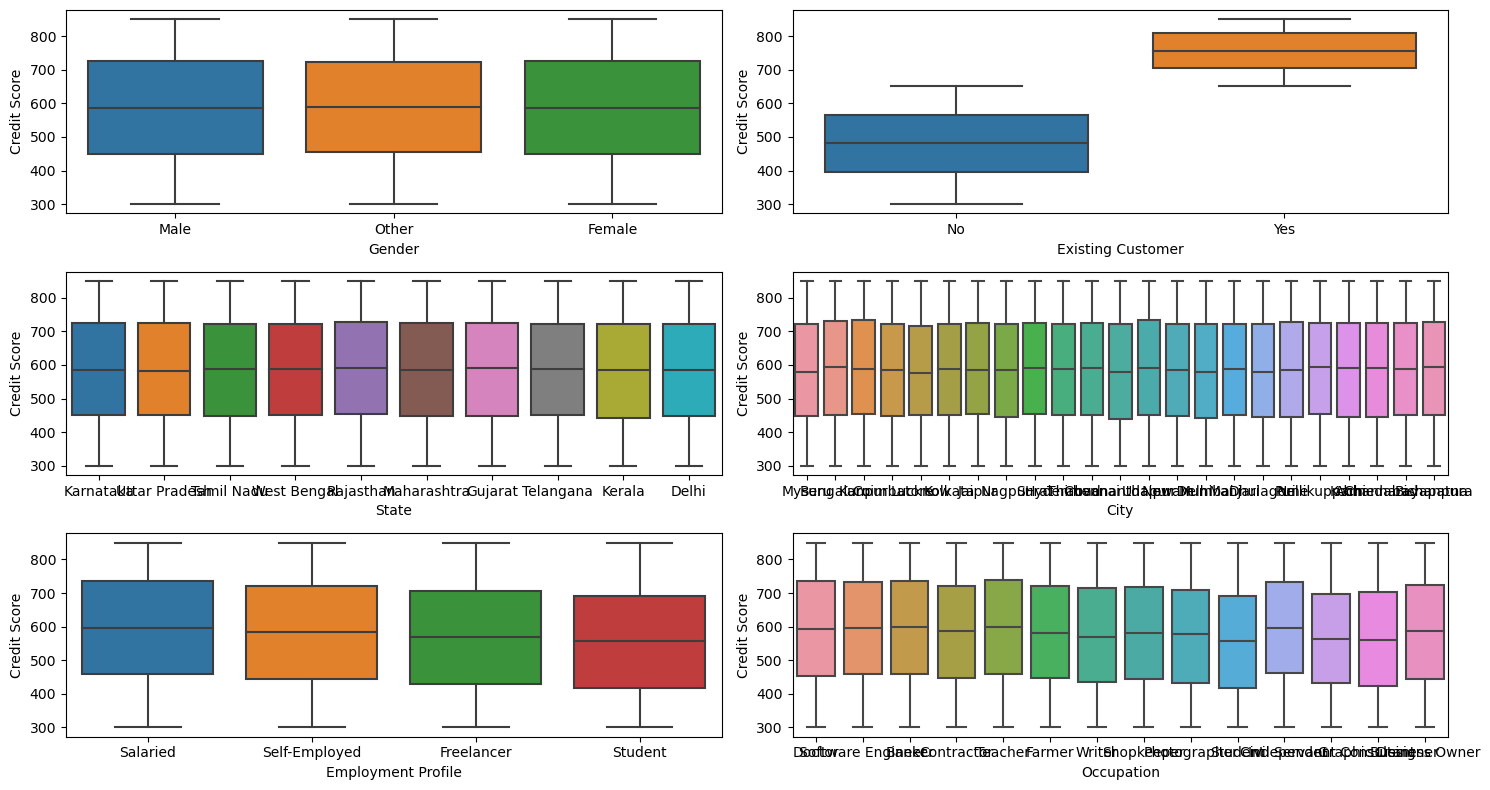

In [16]:
plt.figure(figsize=(15,8))
index = 1

for i in category:
    plt.subplot(3,len(category)//3,index)
    sns.boxplot(x=df[i],y=df['Credit Score'])
    index += 1
    plt.xlabel(i)
    plt.tight_layout()

In [ ]:
#existing customer yes memiliki credit score yang lebih tinggi daripada no 
#selain itu tidak ada insight jelas disini karena distribusi tidak berbeda jauh antar value

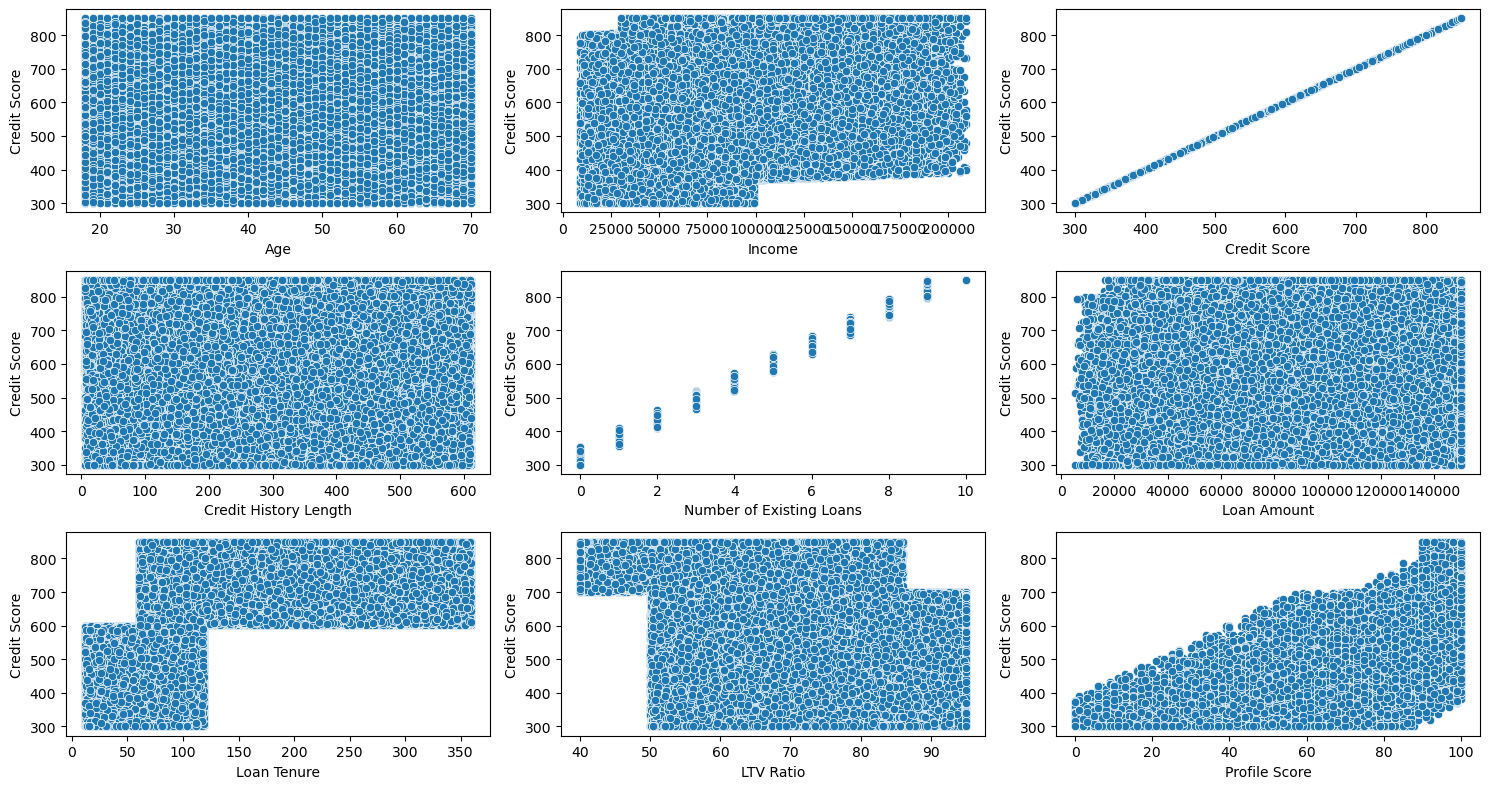

In [6]:
plt.figure(figsize=(15,8))
index = 1

for i in numeric:
    plt.subplot(3,len(numeric)//3,index)
    sns.scatterplot(x=df[i],y=df['Credit Score'])
    index += 1
    plt.xlabel(i)
    plt.tight_layout()

In [ ]:
# semakin tinggi profile score maka semakin tinggi credit score, mungkin karena memang profile score yang lebih tinggi 
#lebih dipercaya 

#number of existing loans semakin tinggi semakin tinggi credit score
#loan tenure dibawah 50 kebanyakan credit score 600 kebawah (atau jangka pembayaran sekitar 4 tahun)
#ltv ratio dibawah 50% tidak ada yang credit scorenya dibawah 700

In [145]:
df[df['LTV Ratio'] <= 50]['Credit Score'].min()

701

In [153]:
df[df['LTV Ratio'] >= 86]['Credit Score'].max()

700

In [202]:
df['Profile Score'].unique()

array([ 77,  43,  90,  86,  92,  25,  58, 100,  87,  13,  95,  49,  82,
        78,  75,  15,  98,  74,  88,  83,  79,  85,  52,  46,  72,  19,
        94,  44,  29,  91,  68,  42,  56,  97,  37,  99,  47,  70,  54,
        73,  32,  31,  96,  69,   0,  65,  33,  93,  66,  62,  60,  81,
        35,  64,  34,  67,  24,  71,  63,  61,  17,  41,  50,  48,  80,
        16,   8,  30,  12,  22,  59,  89,  51,  27,  45,  38,  55,  39,
        76,  23,  10,   2,  18,  57,  40,  53,  11,  84,  14,   3,  26,
         5,  36,   6,   9,  28,  21,  20,   4,   7,   1], dtype=int64)

In [50]:
df[df['Profile Score'] <=5]['Credit Score'].max()

401

In [73]:
df['Number of Existing Loans'].unique()

array([ 5,  2, 10,  6,  1,  8,  4,  0,  9,  3,  7], dtype=int64)

In [8]:
df.groupby('Number of Existing Loans')['Credit Score'].mean().reset_index()

,Number of Existing Loans,Credit Score
0,0,315.501686
1,1,385.006811
2,2,436.948017
3,3,492.021011
4,4,547.154048
5,5,602.166647
6,6,656.666448
7,7,712.218326
8,8,766.924155
9,9,817.175026


In [636]:
df['Age'].unique()

array([31, 25, 62, 69, 52, 64, 29, 30, 39, 68, 19, 59, 26, 57, 42, 34, 20,
       56, 37, 54, 24, 23, 40, 67, 70, 63, 28, 60, 21, 43, 47, 55, 65, 18,
       36, 61, 27, 50, 38, 33, 53, 41, 58, 51, 48, 45, 49, 46, 22, 44, 66,
       35, 32], dtype=int64)

### FEATURING

In [6]:
df2 = df.copy()

In [8]:
# existing customer

df2['Existing Customer'] = np.where(df2['Existing Customer'] == 'Yes',1, 0)

In [113]:
# condition = [
#     df2['Employment Profile'] == 'Salaried',
#     df2['Employment Profile'] == 'Self-Employed',
#     df2['Employment Profile'] == 'Freelancer',
#     df2['Employment Profile'] == 'Student', 
# ]

# choice = ['Salaried','Non Salaried','Non Salaried','Student']

# df2['Employment Profile'] = np.select(condition,choice,default=df2['Employment Profile'])

In [9]:
# Employment profile

dummies_employ = pd.get_dummies(df2['Employment Profile'],dtype=int)
df2 = pd.concat([df2,dummies_employ],axis=1)

# encoder = LabelEncoder()
# df2['Employment Profile'] = encoder.fit_transform(df2['Employment Profile'])

<AxesSubplot:>

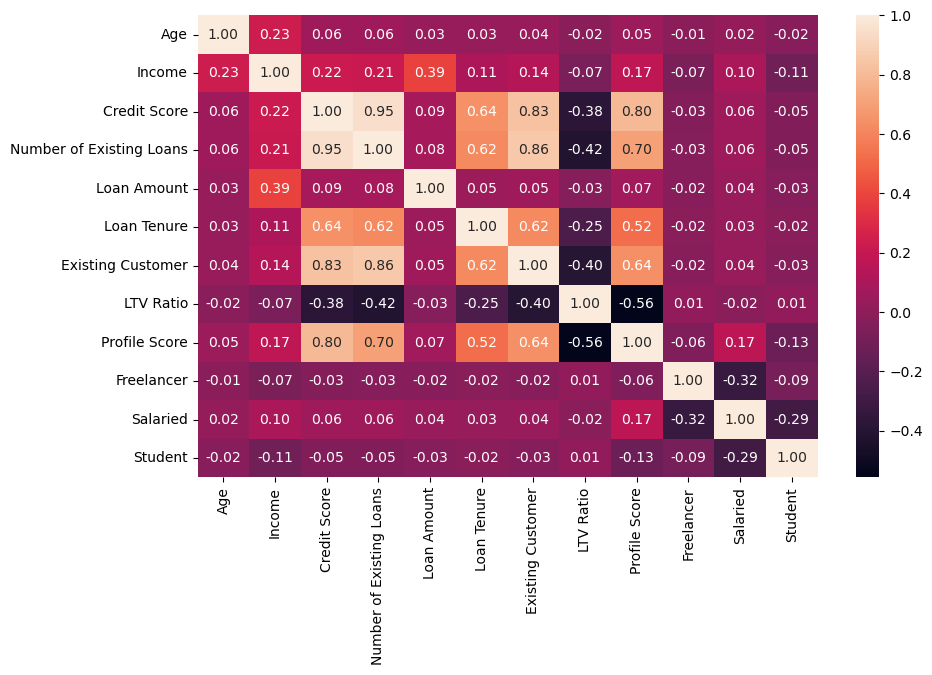

In [15]:
plt.figure(figsize=[10,6])
ds = df2.select_dtypes(include=[float,int])
corr = ds.corr()
sns.heatmap(corr,annot=True,fmt='.2f')

In [48]:
# terjadi multikolinearitas pada existing customer dan number of existing loan

In [49]:
# VIF ANALYSYS
X_matriks = ds[[i for i in ds.columns  if i != 'Credit Score']]
VIF_table(X_matriks)

,col,val
0,Age,2.982408
1,Income,5.546228
2,Number of Existing Loans,9.829890
3,Loan Amount,8.586025
4,Loan Tenure,5.190721
5,Existing Customer,6.575006
6,LTV Ratio,8.011832
7,Profile Score,9.487550
8,Freelancer,1.255660
9,Salaried,2.683442


### FEATURE ENGINEERING

In [135]:
# fitur yang multikolinearitas adalah age ,Number existing loan, ltv, dan profile score

In [10]:
#transformation exponential

df2['Number of Existing Loans'] = df2['Number of Existing Loans'] ** 2
df2['Profile Score'] = df2['Profile Score'] ** 2

In [11]:
#multicolinearity age
condition = [
    df2['Age'] <= 31,
    (df2['Age'] > 31) & (df2['Age'] <=44),
    (df2['Age'] > 44) & (df2['Age'] <=57),
    (df2['Age'] > 57),
]
choice = ['<=31','32-44','45-57','>57']
df2['Age'] = np.select(condition,choice,df2['Age'])
df2['Age'].unique()

array(['<=31', '>57', '45-57', '32-44'], dtype=object)

In [12]:
encoder = LabelEncoder()
df2['Age'] = encoder.fit_transform(df2['Age'])

In [13]:
# drop variabel yang nampaknya tidak fungsional
df2 = df2.drop(['Credit History Length'],axis=1)

In [14]:
df2 = df2.drop(['Self-Employed'],axis=1)

In [30]:
# ds = ds.drop(['Male','Female'],axis = 1)

### SPLIT DATA

In [17]:
train,test = train_test_split(ds,test_size= 0.20,random_state=1)

In [18]:
X_train = train[[i for i in train.columns if i != 'Credit Score']]
y_train = train['Credit Score']

In [19]:
X_test = test[[i for i in ds.columns if i != 'Credit Score']]
y_test = test['Credit Score']

In [345]:
X_train.shape

(133881, 10)

In [87]:
X_test.shape

(33471, 9)

#### FEATURE SCALING

In [20]:
sc = StandardScaler()

col = [i for i in X_train.columns if (i not in ['Salaried','Student','Existing Customer','Freelancer'])]
scaled = sc.fit_transform(X_train[col])
scaled = pd.DataFrame(scaled)
scaled.columns = col
X_train_scaled = pd.concat([scaled,X_train[['Salaried','Student','Existing Customer','Freelancer']].reset_index(drop=True)],axis=1)

test_scaled = sc.transform(X_test[col])
test_scaled = pd.DataFrame(test_scaled)
test_scaled.columns = col
X_test_scaled = pd.concat([test_scaled,X_test[['Salaried','Student','Existing Customer','Freelancer']].reset_index(drop=True)],axis=1)

### MODELING

In [23]:
model = {
    'lr': LinearRegression(),
    'ridge': Ridge(),
    'XGB': XGBRegressor(),
    'Lasso': Lasso()
}

param = {
    'lr': {},
    'XGB':{
        'random_state': [1]
    },
    'ridge':{
        'random_state': [1],
        'max_iter': [1000]
    },
    'Lasso':{
        'random_state': [1],
        'max_iter': [1000]
    },
    'SGD':{
        'random_state': [1],
        'max_iter': [1000]
    },
}

In [24]:
models = {}
test_predict = {}
for i in model.keys():
    gridsearch = GridSearchCV(estimator=model[i],param_grid= param[i],scoring='neg_mean_squared_error',cv=5)
    gridsearch.fit(X_train_scaled,y_train)
    y_pred_train = gridsearch.predict(X_train_scaled)
    models[i] = pd.DataFrame(gridsearch.cv_results_)
    models[i]['RMSE'] = np.sqrt(mean_squared_error(y_train,y_pred_train))
    y_pred = gridsearch.predict(X_test_scaled)
    test_predict[i] = {'MSE': np.mean(y_test - y_pred) **2, 'RMSE': np.sqrt(np.mean(y_test - y_pred)**2)}

In [25]:
# the results
results = pd.concat(models.values(), ignore_index=True)
results['model'] = [i for i in model]
results
retain_cols = ['model','params','mean_test_score','RMSE']
results[retain_cols]
results[retain_cols].sort_values('RMSE')

,model,params,mean_test_score,RMSE
2,XGB,{'random_state': 1},-186.234613,13.056784
0,lr,{},-1512.541581,38.887518
1,ridge,"{'max_iter': 1000, 'random_state': 1}",-1512.541563,38.887518
3,Lasso,"{'max_iter': 1000, 'random_state': 1}",-1539.533613,39.234417


In [168]:
results['mean_test_score']

0   -1561.017391
1   -1561.017381
2    -188.336727
3   -1577.752851
Name: mean_test_score, dtype: float64

In [37]:
#baseline
# model	params	mean_test_score	RMSE
# 2	XGB	{'random_state': 1}	-186.773150	13.000896
# 0	lr	{}	-260.464916	16.137647
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-260.464915	16.137647
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-268.178536	16.375226

#drop credit history length
# model	params	mean_test_score	RMSE
# 2	XGB	{'random_state': 1}	-188.081971	13.097101
# 0	lr	{}	-260.516827	16.139226
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-260.516826	16.139226
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-268.262274	16.377650

#encoding age
# model	params	mean_test_score	RMSE
# 2	XGB	{'random_state': 1}	-188.343927	13.164573
# 0	lr	{}	-260.505704	16.138987
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-260.505703	16.138987
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-268.262274	16.377650

#encoding number of existing loan
# model	params	mean_test_score	RMSE
# 2	XGB	{'random_state': 1}	-188.340782	13.164573
# 0	lr	{}	-1436.789295	37.902272
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-1436.789289	37.902272
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-1453.516231	38.122427

#encoding profile score
# params	mean_test_score	RMSE
# 2	XGB	{'random_state': 1}	-188.336727	13.164573
# 0	lr	{}	-1561.017391	39.506916
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-1561.017381	39.506916
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-1577.752851	39.718378

#encoding employment profile
# 	model	params	mean_test_score	RMSE
# 2	XGB	{'random_state': 1}	-185.933477	13.070167
# 0	lr	{}	-1512.541581	38.887518
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-1512.541567	38.887518
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-1542.998841	39.279234

#standarscaled
# model	params	mean_test_score	RMSE
# 2	XGB	{'random_state': 1}	-186.234613	13.056784
# 0	lr	{}	-1512.541581	38.887518
# 1	ridge	{'max_iter': 1000, 'random_state': 1}	-1512.541563	38.887518
# 3	Lasso	{'max_iter': 1000, 'random_state': 1}	-1539.533613	39.234417

In [25]:
# test predict
pd.DataFrame(test_predict) 

,lr,ridge,XGB,Lasso
MSE,0.027275,0.027280,0.000818,0.033418
RMSE,0.165152,0.165167,0.028595,0.182806


In [ ]:
#baseline
# lr	ridge	XGB	Lasso
# MSE	0.000748	0.000747	0.005360	0.000074
# RMSE	0.027341	0.027339	0.073214	0.008624

#drop credit history length
# lr	ridge	XGB	Lasso
# MSE	0.001365	0.001365	0.000133	0.001105
# RMSE	0.036947	0.036948	0.011512	0.033238

#encoding age
# lr	ridge	XGB	Lasso
# MSE	0.001393	0.001393	0.001183	0.001105
# RMSE	0.037324	0.037325	0.034401	0.033238

#encoding number of existing loan
# lr	ridge	XGB	Lasso
# MSE	0.026117	0.026116	0.001143	0.022915
# RMSE	0.161607	0.161605	0.033801	0.151377

#encoding profile score
# lr	ridge	XGB	Lasso
# MSE	0.039993	0.039993	0.001169	0.035478
# RMSE	0.199983	0.199981	0.034198	0.188355

#employment profile encod
# lr	ridge	XGB	Lasso
# MSE	0.027275	0.027275	0.000403	0.024691
# RMSE	0.165152	0.165151	0.020084	0.157133

#standard scaled
# lr	ridge	XGB	Lasso
# MSE	0.027275	0.027280	0.000818	0.033418
# RMSE	0.165152	0.165167	0.028595	0.182806

### TUNNING

In [156]:
xgb = XGBRegressor()
param = {
    'random_state':[1],
    'max_depth': [19],
    'max_leaves':[2],
    
}

gridsearch = GridSearchCV(estimator=xgb,param_grid= param,scoring='neg_mean_squared_error',cv=5)
gridsearch.fit(X_train_scaled,y_train)
cc = pd.DataFrame(gridsearch.cv_results_)
cc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaves,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,44.298773,0.402845,0.644074,0.03633,19,2,1,"{'max_depth': 19, 'max_leaves': 2, 'random_sta...",-103.661734,-102.913865,-104.760407,-104.380628,-101.860638,-103.515455,1.041168,1


### FINAL MODEL

In [28]:
xgb = XGBRegressor(random_state=1,max_depth=19,max_leaves=2)
model = xgb.fit(X_train_scaled,y_train)
y_pred = model.predict(X_train_scaled)
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)
print(f'MSE : {mse}\nrmse:{rmse}')

MSE : 1.1161003891306114
rmse:1.0564565249600248


In [30]:
y_pred_test = model.predict(X_test_scaled)
mse = mean_squared_error(y_test,y_pred_test)
rmse = np.sqrt(mse)
print(f'MSE : {mse}\nrmse: {rmse}')

MSE : 72.65313519474805
rmse: 8.523680847776273


Age: 0.0001099548680940643
Income: 0.00021370364993344992
Number of Existing Loans: 0.583495557308197
Loan Amount: 0.0003146209637634456
Loan Tenure: 0.0004557600768748671
LTV Ratio: 0.00042279972694814205
Profile Score: 0.0004299852007534355
Salaried: 0.0003343188436701894
Student: 0.0003353466745465994
Existing Customer: 0.4135414659976959
Freelancer: 0.00034649233566597104


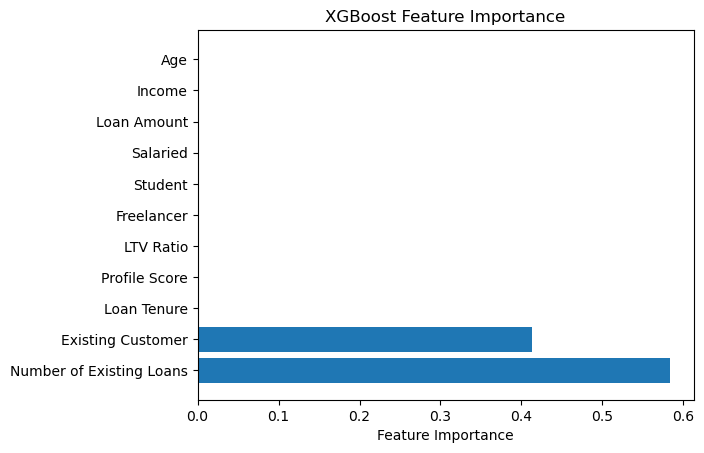

In [33]:
importances = model.feature_importances_

for feature_name, importance in zip(X_train_scaled.columns, importances):
    print(f"{feature_name}: {importance}")
    
sorted_idx = np.argsort(importances)[::-1]
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train_scaled.columns[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

In [ ]:
# feature importances focus on existing customer and number of existing loan